# Bfastmonitor CPU using Python
## This is bfastmonitor Python

In [81]:
import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib
import matplotlib.pyplot as plt

#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import time
import ipywidgets as widgets

from ipyfilechooser import FileChooser
import folium

#specific imports
from functions import set_output_dir, get_size, get_data_dict

In [82]:
%matplotlib inline

## Select a time series folder using ipyfilechooser. The standard download location is in downloads/time_series_name/[0,1,2..n]

### Optional: select a name for your output folder. 

In [83]:
from os.path import expanduser
path = expanduser("~")

def g(directory):
    return(directory)
                          
output_directory_chooser = widgets.interactive(g, 
                        directory=widgets.Text(description="Output storage name:", 
                                               style = {'description_width': 'initial'},
                                               placeholder = "output"))
file_chooser = FileChooser(path)

display(file_chooser)
display(output_directory_chooser)



FileChooser(path='/home/dven', filename='', show_hidden='False')

interactive(children=(Text(value='', description='Output storage name:', placeholder='output', style=Descripti…

In [84]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    set_output_dir(output_directory_chooser)

/home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/
Defaulting to output directory name "output" 


In [97]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
from numpy import isnan

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import time

class Timeseries:
    '''
    
    This is a class that holds a numpy array with time series data, a csv containing dates, and associated geographical metadata.
    
    '''
    
    def __init__(self, time_series_path, dates_path):
        
        self.name = time_series_path + "stack.vrt"
        self.dir = time_series_path
        
        self.time_series = gdal.Open(self.name)
        time_series = self.time_series
        geotransform = time_series.GetGeoTransform()
        
        # geo metadata
        self.xpixelsize = geotransform[1]
        self.ypixelsize = geotransform[5]
        self.latitude = geotransform[3]
        self.longitude = geotransform[0]
        self.ncols = time_series.RasterXSize
        self.nrows = time_series.RasterYSize
        self.projection = time_series.GetProjection()
        self.nbands = time_series.RasterCount
        
        band = time_series.GetRasterBand(1)
        self.block_size = band.GetBlockSize()
        
        # self.raster_stack_orig = time_series.ReadAsArray()
        
        # dates file
        with open(dates_path) as f:
            dates_list = f.read().split('\n')
            self.dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]
        
    def __str__(self):
        return("Timeseries holds {} dates, sized {} by {}.".format(self.nbands,
                                                                        self.ncols,
                                                                        self.nrows))
    def __repr__(self):
            return("Timeseries: {} ".format(self.name))

    def run_bfast(self, block):
        print("start monitor: ", self.start_monitor)
        print("end monitor: ", self.end_monitor)
        print("start history: ", self.start_hist)
        data, dates = crop_data_dates(block, self.dates, self.start_hist, self.end_monitor)
        print("First date: {}".format(dates[0]))
        print("Last date: {}".format(dates[-1]))

        # only apply on a small subset
        #data = data[:,:80,:80]
        
        where_are_NaNs = isnan(data)
        data[where_are_NaNs] = -32768
        data = data.astype("int16")
        start_time = time.time()
        
        self.model.fit(data, dates, nan_value=-32768) #changed to nan
        end_time = time.time()
        print("Fitting model took {} seconds.".format(end_time - start_time))
        
        breaks = self.model.breaks # index of date that has a break in dates
        means = self.model.means # magnitudes of breaks
        return(breaks,means)
    
    def loop_blocks(self):

        x_block_size = 256#self.block_size[0]
        y_block_size = 256#self.block_size[1]
        print("rastersize: ",self.ncols,self.nrows)
        print("blocksize: ",self.block_size)
        print("bytes required: ", str(8 * self.ncols * self.nrows * self.nbands))

        # pseudeocode
        # set x_block_size and y_block_size based on bytes required and available ram

        first_verstack=True

        time_series = self.time_series
        # loop over yblocks
        for i in range(0, self.nrows, y_block_size):
            first_horstack = True
            if i + y_block_size < self.nrows:
                rows = y_block_size
            else:
                rows = self.nrows - i

            # Loop over xblocks
            for j in range(0, self.ncols, x_block_size):
                #counter+=1
                if j + x_block_size < self.ncols:
                    cols = x_block_size
                else:
                    cols = self.ncols - j

                print(j,i,cols,rows)

                # first step creates the array
                if first_horstack==True:
                    data = time_series.ReadAsArray(j, i, cols, rows)

                    breaks,means = self.run_bfast(data)
                    breaks_array = breaks
                    means_array = means
                    first_horstack=False
                    
                # after that add to array
                else:                    
                    data = time_series.ReadAsArray(j, i, cols, rows)
                    
                    breaks,means = self.run_bfast(data)
                    breaks_array = np.concatenate((breaks_array,breaks),axis = 1)
                    means_array = np.concatenate((means_array,means),axis = 1)
                    #data = np.concatenate((data, time_series.ReadAsArray(j, i, cols, rows)),axis=2)
                    
                    print(data.nbytes)

            # first step create new variable verstack for the data
            if first_verstack == True:
                stack_breaks_array = breaks_array
                stack_means_array = means_array
                print(stack_breaks_array)
                first_verstack = False
            # after that add data to array
            else:
                stack_breaks_array = np.concatenate((stack_breaks_array,breaks_array),axis=0)
                stack_means_array = np.concatenate((stack_means_array,means_array),axis=0)
                #verstack_data = np.concatenate((verstack_data, data),axis = 1)
                print(stack_breaks_array)

        #self.raster_stack = verstack_data
        self.breaks_array = stack_breaks_array
        
        self.means_array = stack_means_array
        
        # numpy raster
        
        # what we want to do is try to download the whole tile, if it doesn't work, do it per block and then merge? 
        #self.raster_stack = time_series.ReadAsArray()
    
    def set_bfast_parameters(self, start_monitor, end_monitor, start_hist,freq,k,hfrac,trend,level,backend='python',verbose=1):
        self.start_monitor = start_monitor
        self.end_monitor = end_monitor
        self.start_hist = start_hist
        
        self.model = BFASTMonitor(
                    self.start_monitor,
                    freq=freq, # add these
                    k=k,
                    hfrac=hfrac,
                    trend=trend,
                    level=level,
                    backend='opencl',
                    verbose=1,
                    device_id=0,
                    )
        
    def get_bfast_parameters(self):
        print(self.model)
    
    
    # Don't work anymore, fix later
    def plot_hist(self):
        histlist = []
        for x in range(self.nbands):
            histlist.append(np.isnan(self.raster_stack[x]).sum()/(self.ncols*self.nrows))
        plt.hist(histlist)
        plt.show()
        
    def get_size(self):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(self.dir):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                # skip if it is symbolic link
                if not os.path.islink(fp):
                    total_size += os.path.getsize(fp)
        print(self.dir + "   holds  " + str(total_size) + " bytes")

      

# Load in data: if there are tiles in the directory, create a list and load per tile

In [98]:
start_time = time.time()

# # set paths to data
dates_path = os.path.join(timeseries_directory, "dates.csv")
data_list=[]
tile_paths = []

# # check for tiles
for file in os.listdir(timeseries_directory):
    if file.startswith('tile'):
        time_series_path =  timeseries_directory + file + "/"
        tile_paths.append(time_series_path)


In [107]:
# # load in time series and its metadata
if not tile_paths:
    print("No tiles, loading in data as a whole")
#     time_series_path = os.path.join(timeseries_directory, 'stack.vrt')
    ts_data = Timeseries(timeseries_directory, dates_path)
    data_list.append(ts_data)
    
else:
    print("Data consists of tiles, loading in tiles one by one")
    for time_series_path in tile_paths:
        ts_data = Timeseries(time_series_path, dates_path)
        data_list.append(ts_data)
        
        end_time = time.time()
        print(time_series_path, ' loaded \n', "Loading data took {} seconds.".format(end_time - start_time))

# Save time and log
end_time = time.time()
#print("Total loading took {} seconds.".format(end_time - start_time))

# log
with open("log.txt","a") as file:
    file.write("Loading in: " + timeseries_directory)
    file.write(" took {} seconds.".format(end_time - start_time))
    file.write("\n")

Data consists of tiles, loading in tiles one by one
/home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000000000-0000000000/  loaded 
 Loading data took 283.8835849761963 seconds.
/home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000002048-0000002048/  loaded 
 Loading data took 283.89866828918457 seconds.
/home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000006144-0000004096/  loaded 
 Loading data took 283.90846729278564 seconds.
/home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000004096-0000006144/  loaded 
 Loading data took 283.91804814338684 seconds.
/home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000000000-0000002048/  loaded 
 Loading data took 283.9360797405243 seconds.
/home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000006144-0000006144/  loaded 
 Loading data took 283.94634461402893 seconds.
/home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000002

AttributeError: 'Timeseries' object has no attribute 'raster_stack'

### Check some metadata of the created Timeseries class

In [108]:
for ts_data in data_list:
    #ts_data.get_size()
    #ts_data.plot_hist()
    print("projection: ", ts_data.projection)
    print("pixel size: ", ts_data.xpixelsize)

projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.0002694945852358554
projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.0002694945852358554
projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.0002694945852358554
projection:  GEOGCS["W

# Set parameters

In [109]:
# make a big ipywidget part

# parameters
k = 3
freq = 365
trend = False
hfrac = 0.25
level = 0.05
start_hist = datetime(2018, 1, 1)
start_monitor = datetime(2019, 1, 1)
end_monitor = datetime(2020, 1, 1)
position = (100,100)






Timeseries holds 197 dates, sized 2048 by 508.


In [ ]:
dates = ts_data.dates
start_date = dates[10] # 0 or 10 does not work.. 100 did
print("start monitoring period",start_date)
end_date = dates[-1]

def h(y):
    return(y)

pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)


monitoring_period = widgets.interactive(h,
                                     y=widgets.SelectionRangeSlider(
                                            options=options,
                                            index=index,
                                            description='Select the monitoring date range: ',
                                            style = {'description_width': 'initial'},
                                            orientation='horizontal',
                                            layout={'width': '800px',"height":"50px"}))


history_period = widgets.interactive(h, 
                                     y=widgets.SelectionSlider(description="Start history period:", 
                                            options = options,
                                            style = {'description_width': 'initial'}))

display(monitoring_period)
display(history_period)

In [ ]:
start_monitor, end_monitor = monitoring_period.result
start_hist = history_period.result

if history_period.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

#start_monitor = datetime(2007, 10, 3)

print("start monitor: ", start_monitor)
print("end monitor: ", end_monitor)
print("start history: ", start_hist)

In [ ]:

#ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level)


### if you have tiles loop over them, or select the first

In [111]:


# for ts_data in data_list:
#     ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level)
#     ts_data.loop_blocks()

    
ts_data = data_list[0]
ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level)
print(ts_data.start_monitor)
#ts_data.loop_blocks()

2019-01-01 00:00:00


In [112]:
# If you have no tiles:
ts_data.loop_blocks()

rastersize:  2048 2048
blocksize:  [128, 128]
bytes required:  6610223104
0 0 256 256
start monitor:  2019-01-01 00:00:00
end monitor:  2020-01-01 00:00:00
start history:  2018-01-01 00:00:00
First date: 2018-01-08 00:00:00
Last date: 2019-12-30 00:00:00
--- runtime for data initialization:		0.0035266876220703125
--- runtime for data transfer (host->device):	0.00490570068359375
--- runtime for data preprocessing:		0.002086162567138672
--- runtime for kernel execution:		0.007966995239257812
--- runtime for data transfer (device->host):	0.0015583038330078125
256 0 256 256
start monitor:  2019-01-01 00:00:00
end monitor:  2020-01-01 00:00:00
start history:  2018-01-01 00:00:00
First date: 2018-01-08 00:00:00
Last date: 2019-12-30 00:00:00
--- runtime for data initialization:		0.0018472671508789062
--- runtime for data transfer (host->device):	0.004749298095703125
--- runtime for data preprocessing:		0.001975536346435547
--- runtime for kernel execution:		0.007929325103759766
--- runtime f

start monitor:  2019-01-01 00:00:00
end monitor:  2020-01-01 00:00:00
start history:  2018-01-01 00:00:00
First date: 2018-01-08 00:00:00
Last date: 2019-12-30 00:00:00
--- runtime for data initialization:		0.0018663406372070312
--- runtime for data transfer (host->device):	0.0048258304595947266
--- runtime for data preprocessing:		0.002047300338745117
--- runtime for kernel execution:		0.007990598678588867
--- runtime for data transfer (device->host):	0.0015604496002197266
256 512 256 256
start monitor:  2019-01-01 00:00:00
end monitor:  2020-01-01 00:00:00
start history:  2018-01-01 00:00:00
First date: 2018-01-08 00:00:00
Last date: 2019-12-30 00:00:00
--- runtime for data initialization:		0.0018308162689208984
--- runtime for data transfer (host->device):	0.004808902740478516
--- runtime for data preprocessing:		0.0020151138305664062
--- runtime for kernel execution:		0.007913351058959961
--- runtime for data transfer (device->host):	0.0015535354614257812
51642368
512 512 256 256
s

start monitor:  2019-01-01 00:00:00
end monitor:  2020-01-01 00:00:00
start history:  2018-01-01 00:00:00
First date: 2018-01-08 00:00:00
Last date: 2019-12-30 00:00:00
--- runtime for data initialization:		0.0018982887268066406
--- runtime for data transfer (host->device):	0.004912137985229492
--- runtime for data preprocessing:		0.0020720958709716797
--- runtime for kernel execution:		0.008010625839233398
--- runtime for data transfer (device->host):	0.0014259815216064453
256 1024 256 256
start monitor:  2019-01-01 00:00:00
end monitor:  2020-01-01 00:00:00
start history:  2018-01-01 00:00:00
First date: 2018-01-08 00:00:00
Last date: 2019-12-30 00:00:00
--- runtime for data initialization:		0.0018188953399658203
--- runtime for data transfer (host->device):	0.0047914981842041016
--- runtime for data preprocessing:		0.001981973648071289
--- runtime for kernel execution:		0.007924079895019531
--- runtime for data transfer (device->host):	0.0015668869018554688
51642368
512 1024 256 256

start monitor:  2019-01-01 00:00:00
end monitor:  2020-01-01 00:00:00
start history:  2018-01-01 00:00:00
First date: 2018-01-08 00:00:00
Last date: 2019-12-30 00:00:00
--- runtime for data initialization:		0.003352642059326172
--- runtime for data transfer (host->device):	0.0048084259033203125
--- runtime for data preprocessing:		0.002020597457885742
--- runtime for kernel execution:		0.00792384147644043
--- runtime for data transfer (device->host):	0.001558542251586914
256 1536 256 256
start monitor:  2019-01-01 00:00:00
end monitor:  2020-01-01 00:00:00
start history:  2018-01-01 00:00:00
First date: 2018-01-08 00:00:00
Last date: 2019-12-30 00:00:00
--- runtime for data initialization:		0.0034863948822021484
--- runtime for data transfer (host->device):	0.004859209060668945
--- runtime for data preprocessing:		0.0020685195922851562
--- runtime for kernel execution:		0.007937431335449219
--- runtime for data transfer (device->host):	0.0015749931335449219
51642368
512 1536 256 256
st

# Select monitoring period

start monitoring period 2000-03-04 00:00:00


interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 7400), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2000-03-04', Timestamp('…

start monitor:  2007-10-03 00:00:00
end monitor:  2020-06-07 00:00:00
start history:  2000-03-04 00:00:00


First date: 2000-03-28 00:00:00
Last date: 2020-06-07 00:00:00
Shape of data array: (527, 8, 14)


# Run bfastmonitor()

Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Fitting model took 1.3845024108886719 seconds.


# Select negative magnitudes

In [113]:
# select only negative magnitudes
#breaks = model.breaks # index of date that has a break in dates
#means = model.means # magnitudes of breaks

breaks = ts_data.breaks_array
means = ts_data.means_array

no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan


In [116]:
dates_monitor = []
dates = ts_data.dates
# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


2020

# Classify output for plotting

In [117]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 
    
print(idx_starts)
breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))

    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        continue
    
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1
        continue
        
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
print(ticklist)
print(breaks_plot_years)

{2019: 0}


KeyError: 2020

# Plot output

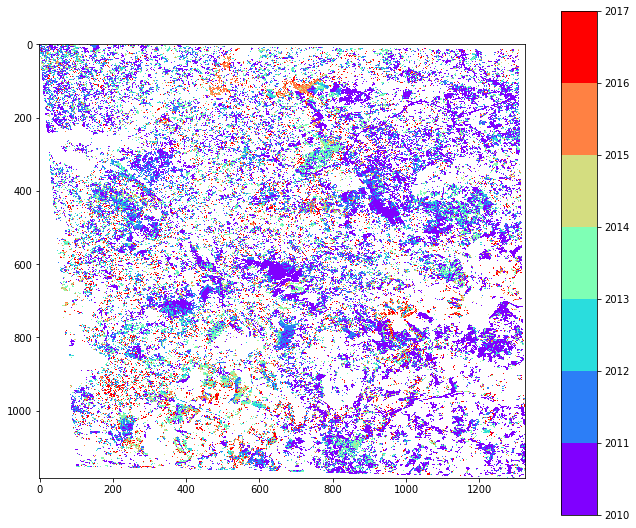

In [72]:
bins = len(idx_starts)

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./output/picture.png")
plt.show()


In [45]:
# #this doesn't work yet

# output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',cols, rows, 1 ,gdal.GDT_Float32)  # Open the file

# output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
# srs = osr.SpatialReference()                 # Establish its coordinate encoding
# srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
#                                              # Anyone know how to specify the 
#                                              # IAU2000:49900 Mars encoding?
# output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#                                                    # to the file
# output_raster.GetRasterBand(1).WriteArray(breaks_plot_years)   # Writes my array to the raster

# output_raster.FlushCache()

# output_raster

In [73]:
print(breaks_plot_years)
breaks_plot_years_norm = 1/(breaks_plot_years + 0.01)
print(breaks_plot_years_norm)

[[nan nan nan ... nan nan nan]
 [ 7.  7.  2. ... nan nan nan]
 [ 7.  7.  2. ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[       nan        nan        nan ...        nan        nan        nan]
 [0.14265335 0.14265335 0.49751244 ...        nan        nan        nan]
 [0.14265335 0.14265335 0.49751244 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [74]:
#cmap = plt.get_cmap("Oranges")

#cmaplist = [cmap(i) for i in range(cmap.N)]

#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# viridis = cm.get_cmap('viridis', 12)
# print(viridis)
# print(viridis(0.56))

viridis = cm.get_cmap('rainbow', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 0])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

In [60]:
print(latitude)
print(xpixelsize)
print(cols)
print(longitude)
print(ypixelsize)
print(rows)

NameError: name 'latitude' is not defined

In [80]:
from folium.plugins import FloatImage
import base64
latitude = ts_data.latitude
longitude = ts_data.longitude
xpixelsize= ts_data.xpixelsize
ypixelsize= ts_data.ypixelsize
rows = ts_data.nrows
cols = ts_data.ncols

m = folium.folium.Map(location = (latitude,longitude),tiles = "Stamen Terrain",zoom_start=13)

# if not all data is 
#rows = 200
#cols = 200


# bounds = [[lat_min, lon_min], [lat_max, lon_max]]

folium.raster_layers.ImageOverlay(
    image=breaks_plot_years_norm,
    bounds=[[latitude, longitude], [latitude + rows*xpixelsize, longitude + cols*xpixelsize]],
    colormap = newcmp
).add_to(m)
img = "output/picture.png" 


####
resolution, width, height = 75, 4,4
encoded = base64.b64encode(open("output/picture.png", 'rb').read()).decode()
from folium import IFrame

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=icon)
marker.add_to(m)
####

m.save(os.path.join('output/PortugalBigger_gpu.html'))
m